In [1]:
#importamos las librerias necesarias

import pandas as pd
import numpy as np
import plotly.express as px
import plotly as pl
import re
pl.offline.init_notebook_mode(connected=True)

In [2]:
#leemos los datos de properatti

data= "../Data/properatti.csv"
propiedades= pd.read_csv(data)

propiedades.state_name.value_counts()

propiedades.price_usd_per_m2.describe()

count     68617.000000
mean       2160.086916
std        2759.288621
min           0.600000
25%        1218.181818
50%        1800.000000
75%        2486.411765
max      206333.333333
Name: price_usd_per_m2, dtype: float64

In [3]:
#listamos las columnas

propiedades.columns

Index(['Unnamed: 0', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail'],
      dtype='object')

In [4]:
cols = propiedades.select_dtypes(include=[np.object]).columns
propiedades[cols]= propiedades[cols].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))
#propiedades.dtypes

In [5]:
propiedades.dtypes

Unnamed: 0                      int64
operation                      object
property_type                  object
place_name                     object
place_with_parent_names        object
country_name                   object
state_name                     object
geonames_id                   float64
lat-lon                        object
lat                           float64
lon                           float64
price                         float64
currency                       object
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                         float64
expenses                      float64
properati_url                  object
description                    object
title                          object
image_thumbnail                object
dtype: objec

In [6]:
const=pd.unique(propiedades.place_name)
const

array(['Mataderos', 'La Plata', 'Liniers', ..., 'Laguna Paiva',
       'Malabrigo', 'Altos de Hudson I'], dtype=object)

In [7]:
#propiedades.price.apply(lambda x: x['price']*180)
#propiedades.loc[(propiedades.place_name=="Boedo") & (propiedades.currency=="ARS")].state_name.value_counts()

#creamos un dataframe nuevo tomando en cuenta solo las propiedades de Capital Federal
propiedades_capital=propiedades.loc[(propiedades.state_name=="Capital Federal")]
propiedades_capital.groupby('place_name').price_usd_per_m2.max()

place_name
Abasto               2939.393939
Agronomia            2638.297872
Almagro             25190.322581
Balvanera           13066.666667
Barracas            29562.500000
                        ...     
Villa Riachuelo      1333.333333
Villa Santa Rita     2403.846154
Villa Soldati        1720.000000
Villa Urquiza       14750.000000
Villa del Parque     8300.000000
Name: price_usd_per_m2, Length: 62, dtype: float64

In [8]:
#propiedades_capital.apply(lambda x: x['price']/180 if x['currency']!='USD' else x)
#propiedades_capital.loc[(propiedades_capital.currency!='USD')].apply(lambda x: x['price']/180)
#propiedades_capital['precio_dolar']=propiedades_capital.apply(lambda x: x['price']/180 if x['currency']!='USD' else x,axis=1).price.mean()

In [9]:
propiedades_capital.columns

Index(['Unnamed: 0', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail'],
      dtype='object')

In [10]:
#creamos una serie dummy para saber el tipo de cambio utilizado a la fecha del registro

dummy=propiedades_capital['price_aprox_local_currency']/propiedades_capital['price_aprox_usd']
tasa_cambio=dummy.mean()
tasa_cambio

17.644499993856833

In [11]:
#creamos una serie nueva tomando el promedio del m2 en dolares con respecto al barrio (lo usaremos posteriormente para llenas los NaN)

pricem2USD_fill_values=propiedades_capital.groupby('place_name').price_usd_per_m2.mean()
pricem2USD_fill_values

#propiedades_capital2[['price', 'currency',
#       'price_aprox_local_currency', 'price_aprox_usd','price_usd_per_m2']].loc[propiedades_capital2.currency!='USD'].head(20)

place_name
Abasto              2057.529147
Agronomia           2088.124134
Almagro             2749.102521
Balvanera           1982.249390
Barracas            1969.946866
                       ...     
Villa Riachuelo     1110.690766
Villa Santa Rita    1889.186620
Villa Soldati        743.666758
Villa Urquiza       2495.288265
Villa del Parque    2233.837905
Name: price_usd_per_m2, Length: 62, dtype: float64

In [12]:
#creamos un dataFrame nuevo con los valores de la serie obtenida anteriormente y hacemos un merge a propiedades_capital2 en una nueva columna 
#con el promedio del m2 en dolares

pricem2USD_fill_values_df= pd.DataFrame(pricem2USD_fill_values)
pricem2USD_fill_values_df.reset_index(inplace=True)
propiedades_capital2=propiedades_capital.merge(pricem2USD_fill_values_df, on= 'place_name', how='left', suffixes = ("", "_mean"))
propiedades_capital2.head(3)

Unnamed: 0 operation property_type place_name  \
0           0      sell            PH  Mataderos   
1           2      sell     apartment  Mataderos   
2           3      sell            PH    Liniers   

                 place_with_parent_names country_name       state_name  \
0  |Argentina|Capital Federal|Mataderos|    Argentina  Capital Federal   
1  |Argentina|Capital Federal|Mataderos|    Argentina  Capital Federal   
2    |Argentina|Capital Federal|Liniers|    Argentina  Capital Federal   

   geonames_id                  lat-lon        lat  ...  price_usd_per_m2  \
0    3430787.0  -34.6618237,-58.5088387 -34.661824  ...       1127.272727   
1    3430787.0  -34.6522615,-58.5229825 -34.652262  ...       1309.090909   
2    3431333.0  -34.6477969,-58.5164244 -34.647797  ...               NaN   

   price_per_m2 floor  rooms  expenses  \
0   1550.000000   NaN    NaN       NaN   
1   1309.090909   NaN    NaN       NaN   
2           NaN   NaN    NaN       NaN   

                                       properati_url  \
0  http://www.properati.com.ar/15bo8_venta_ph_mat...   
1  http://www.properati.com.ar/15bod_venta_depart...   
2  http://www.properati.com.ar/15boh_venta_ph_lin...   

                                         description  \
0  2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...   
1  2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...   
2  PH 3 ambientes con patio. Hay 3 deptos en lote...   

                                      title  \
0        2 AMB TIPO CASA SIN EXPENSAS EN PB   
1  2 AMB 3ER PISO CON ASCENSOR APTO CREDITO   
2              PH 3 amb. cfte. reciclado      

                                     image_thumbnail  price_usd_per_m2_mean  
0  https://thumbs4.properati.com/8/BluUYiHJLhgIIK...            1552.250025  
1  https://thumbs4.properati.com/5/SXKr34F_IwG3W_...            1552.250025  
2  https://thumbs4.properati.com/3/DgIfX-85Mog5SP...            1803.908335  

[3 rows x 27 columns]

In [13]:
propiedades_capital2.columns

Index(['Unnamed: 0', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail', 'price_usd_per_m2_mean'],
      dtype='object')

In [14]:
#usamos fillna para substituir los NaN con los valores en la columna price_usd_per_m2_mean
propiedades_capital2.price_usd_per_m2.fillna(propiedades_capital2.price_usd_per_m2_mean, inplace = True)

In [15]:
#chequeamos que no existan NaN en price_usd_per_m2
propiedades_capital2.price_usd_per_m2.isna().count

<bound method Series.count of 0        False
1        False
2        False
3        False
4        False
         ...  
32311    False
32312    False
32313    False
32314    False
32315    False
Name: price_usd_per_m2, Length: 32316, dtype: bool>

In [16]:
#lo vemos graficamente
propiedades_capital2.property_type.head(5)

0           PH
1    apartment
2           PH
3    apartment
4    apartment
Name: property_type, dtype: object

In [17]:
pricem2USD_fill_values_df= pd.DataFrame(pricem2USD_fill_values)
pricem2USD_fill_values_df.reset_index(inplace=True)
propiedades_capital2=propiedades_capital.merge(pricem2USD_fill_values_df, on= 'place_name', how='left', suffixes = ("", "_mean"))

In [18]:
#propiedades_capital2.dna(ropaxis=1, columns='price')
propiedades_capital2.property_type.value_counts()

apartment    27037
house         2087
PH            1828
store         1364
Name: property_type, dtype: int64

In [19]:
propiedades_capital2[['property_type','price','place_name','currency','price_usd_per_m2']].head(50)

property_type      price       place_name currency  price_usd_per_m2
0             PH    62000.0        Mataderos      USD       1127.272727
1      apartment    72000.0        Mataderos      USD       1309.090909
2             PH    95000.0          Liniers      USD               NaN
3      apartment   138000.0         Belgrano      USD       3066.666667
4      apartment   195000.0         Belgrano      USD       3000.000000
5      apartment   111700.0     Palermo Soho      USD       2234.000000
6      apartment   147900.0     Palermo Soho      USD       3521.428571
7             PH   239000.0        Mataderos      USD       1707.142857
8      apartment   350000.0          Palermo      USD       3365.384615
9      apartment   270500.0          Palermo      USD       2292.372881
10     apartment    75000.0           Flores      USD       1744.186047
11     apartment   145000.0            Boedo      USD       1812.500000
12     apartment   480000.0      Las Canitas      USD       2181.818182
13         house    70000.0    Puerto Madero      USD        875.000000
14     apartment   240000.0        Balvanera      USD       1702.127660
15         house   550000.0            Boedo      USD       1091.269841
16     apartment   110000.0        Caballito      USD       2200.000000
17     apartment   170500.0        Caballito      USD       1705.000000
18     apartment   220410.0        Caballito      USD       2721.111111
19     apartment   222780.0        Caballito      USD       2750.370370
20         store   250000.0         Belgrano      USD       8333.333333
21     apartment   108000.0        Caballito      USD       1542.857143
22     apartment   173000.0            Nunez      USD       3460.000000
23     apartment    72900.0            Boedo      USD       1918.421053
24     apartment  1423800.0        San Telmo      ARS               NaN
25     apartment   109900.0          Almagro      USD       2198.000000
26         house   170000.0  Capital Federal      USD        944.444444
27         house   490000.0  Capital Federal      USD        658.602151
28         house   440000.0  Capital Federal      USD        611.111111
29         house   320000.0  Capital Federal      USD       1600.000000
30     apartment   178000.0         Belgrano      USD               NaN
31         house   370000.0  Capital Federal      USD       1088.235294
32            PH   249000.0       Colegiales      USD               NaN
33         house   219500.0         Floresta      USD        365.833333
34     apartment   129000.0        Balvanera      USD               NaN
35     apartment   128000.0        Caballito      USD               NaN
36     apartment   118000.0        Balvanera      USD               NaN
37     apartment    93000.0     Barrio Norte      USD               NaN
38            PH   160000.0         Barracas      USD       1025.641026
39     apartment   380000.0         Recoleta      USD       1938.775510
40            PH   315000.0          Palermo      USD       1312.500000
41         store   295000.0         Congreso      USD       2864.077670
42     apartment    73800.0     Villa Crespo      USD       1757.142857
43     apartment    72000.0     Villa Crespo      USD       1636.363636
44     apartment   235000.0      Las Canitas      USD       3455.882353
45     apartment   240000.0         Belgrano      USD       4210.526316
46     apartment        NaN        Caballito      NaN               NaN
47         store   175000.0        Chacarita      USD       2187.500000
48     apartment   550000.0         Belgrano      USD       3437.500000
49     apartment        NaN        Caballito      NaN               NaN

In [20]:
propiedades_capital2.loc[propiedades_capital2.place_name=='Boedo'].price_usd_per_m2.nlargest(10)

7002    206333.333333
6541    173826.066667
6654    104486.114286
6395     78533.333333
6261     34608.000000
5926     34534.482759
5890     32486.486486
6533     25298.666667
6672     25281.833333
6796     25280.500000
Name: price_usd_per_m2, dtype: float64

In [21]:
propiedades_capital_boedo=propiedades_capital2[['property_type','price','place_name','currency','surface_total_in_m2','price_usd_per_m2']].loc[propiedades_capital2.place_name=='Boedo']
propiedades_capital_boedo.sort_values(by='price_usd_per_m2', axis=0, ascending=False)

property_type      price place_name currency  surface_total_in_m2  \
7002      apartment  6809000.0      Boedo      USD                 33.0   
6541      apartment  5214782.0      Boedo      USD                 30.0   
6654      apartment  3657014.0      Boedo      USD                 35.0   
6395      apartment  2356000.0      Boedo      USD                 30.0   
6261      apartment   865200.0      Boedo      USD                 25.0   
...             ...        ...        ...      ...                  ...   
31545     apartment    98000.0      Boedo      USD                  NaN   
31647         store   350000.0      Boedo      USD                  NaN   
32051     apartment        NaN      Boedo      NaN                 84.0   
32077            PH        NaN      Boedo      NaN                350.0   
32187            PH        NaN      Boedo      NaN                 78.0   

       price_usd_per_m2  
7002      206333.333333  
6541      173826.066667  
6654      104486.114286  
6395       78533.333333  
6261       34608.000000  
...                 ...  
31545               NaN  
31647               NaN  
32051               NaN  
32077               NaN  
32187               NaN  

[890 rows x 6 columns]

In [22]:
print("Desviacion de boedo "+str(propiedades_capital_boedo.price_usd_per_m2.std()))
print("Media de boedo "+str(propiedades_capital_boedo.price_usd_per_m2.mean()))
print("3 deviaciones de boedo "+str(((propiedades_capital_boedo.mean())+(propiedades_capital_boedo.std()*3))))
propiedades_capital_boedo.price_usd_per_m2.describe()

Desviacion de boedo 13188.768865631684
Media de boedo 10697.513056197955
3 deviaciones de boedo price                  1.881897e+06
surface_total_in_m2    2.274817e+02
price_usd_per_m2       5.026382e+04
dtype: float64


count       800.000000
mean      10697.513056
std       13188.768866
min         789.473684
25%        1675.405844
50%        7661.666667
75%       18322.849462
max      206333.333333
Name: price_usd_per_m2, dtype: float64

In [23]:
propiedades_capital_boedo2=propiedades_capital_boedo[['price_usd_per_m2','place_name']]
propiedades_capital_boedo2.describe()
removed_outliers = propiedades_capital2.price_usd_per_m2.between(propiedades_capital2.price_usd_per_m2.quantile(.05), propiedades_capital2.price_usd_per_m2.quantile(.95))
print(propiedades_capital2.price_usd_per_m2.mean())
print(propiedades_capital2.price_usd_per_m2[removed_outliers].mean())
#propiedades_capital_boedo2.price_usd_per_m2=[propiedades_capital_boedo2.price_usd_per_m2.between(propiedades_capital_boedo2.price_usd_per_m2.quantile(.15), propiedades_capital_boedo2.price_usd_per_m2.quantile(.85))] 

3116.9304442658454
2610.332573908606


<AxesSubplot:xlabel='Barrios'>

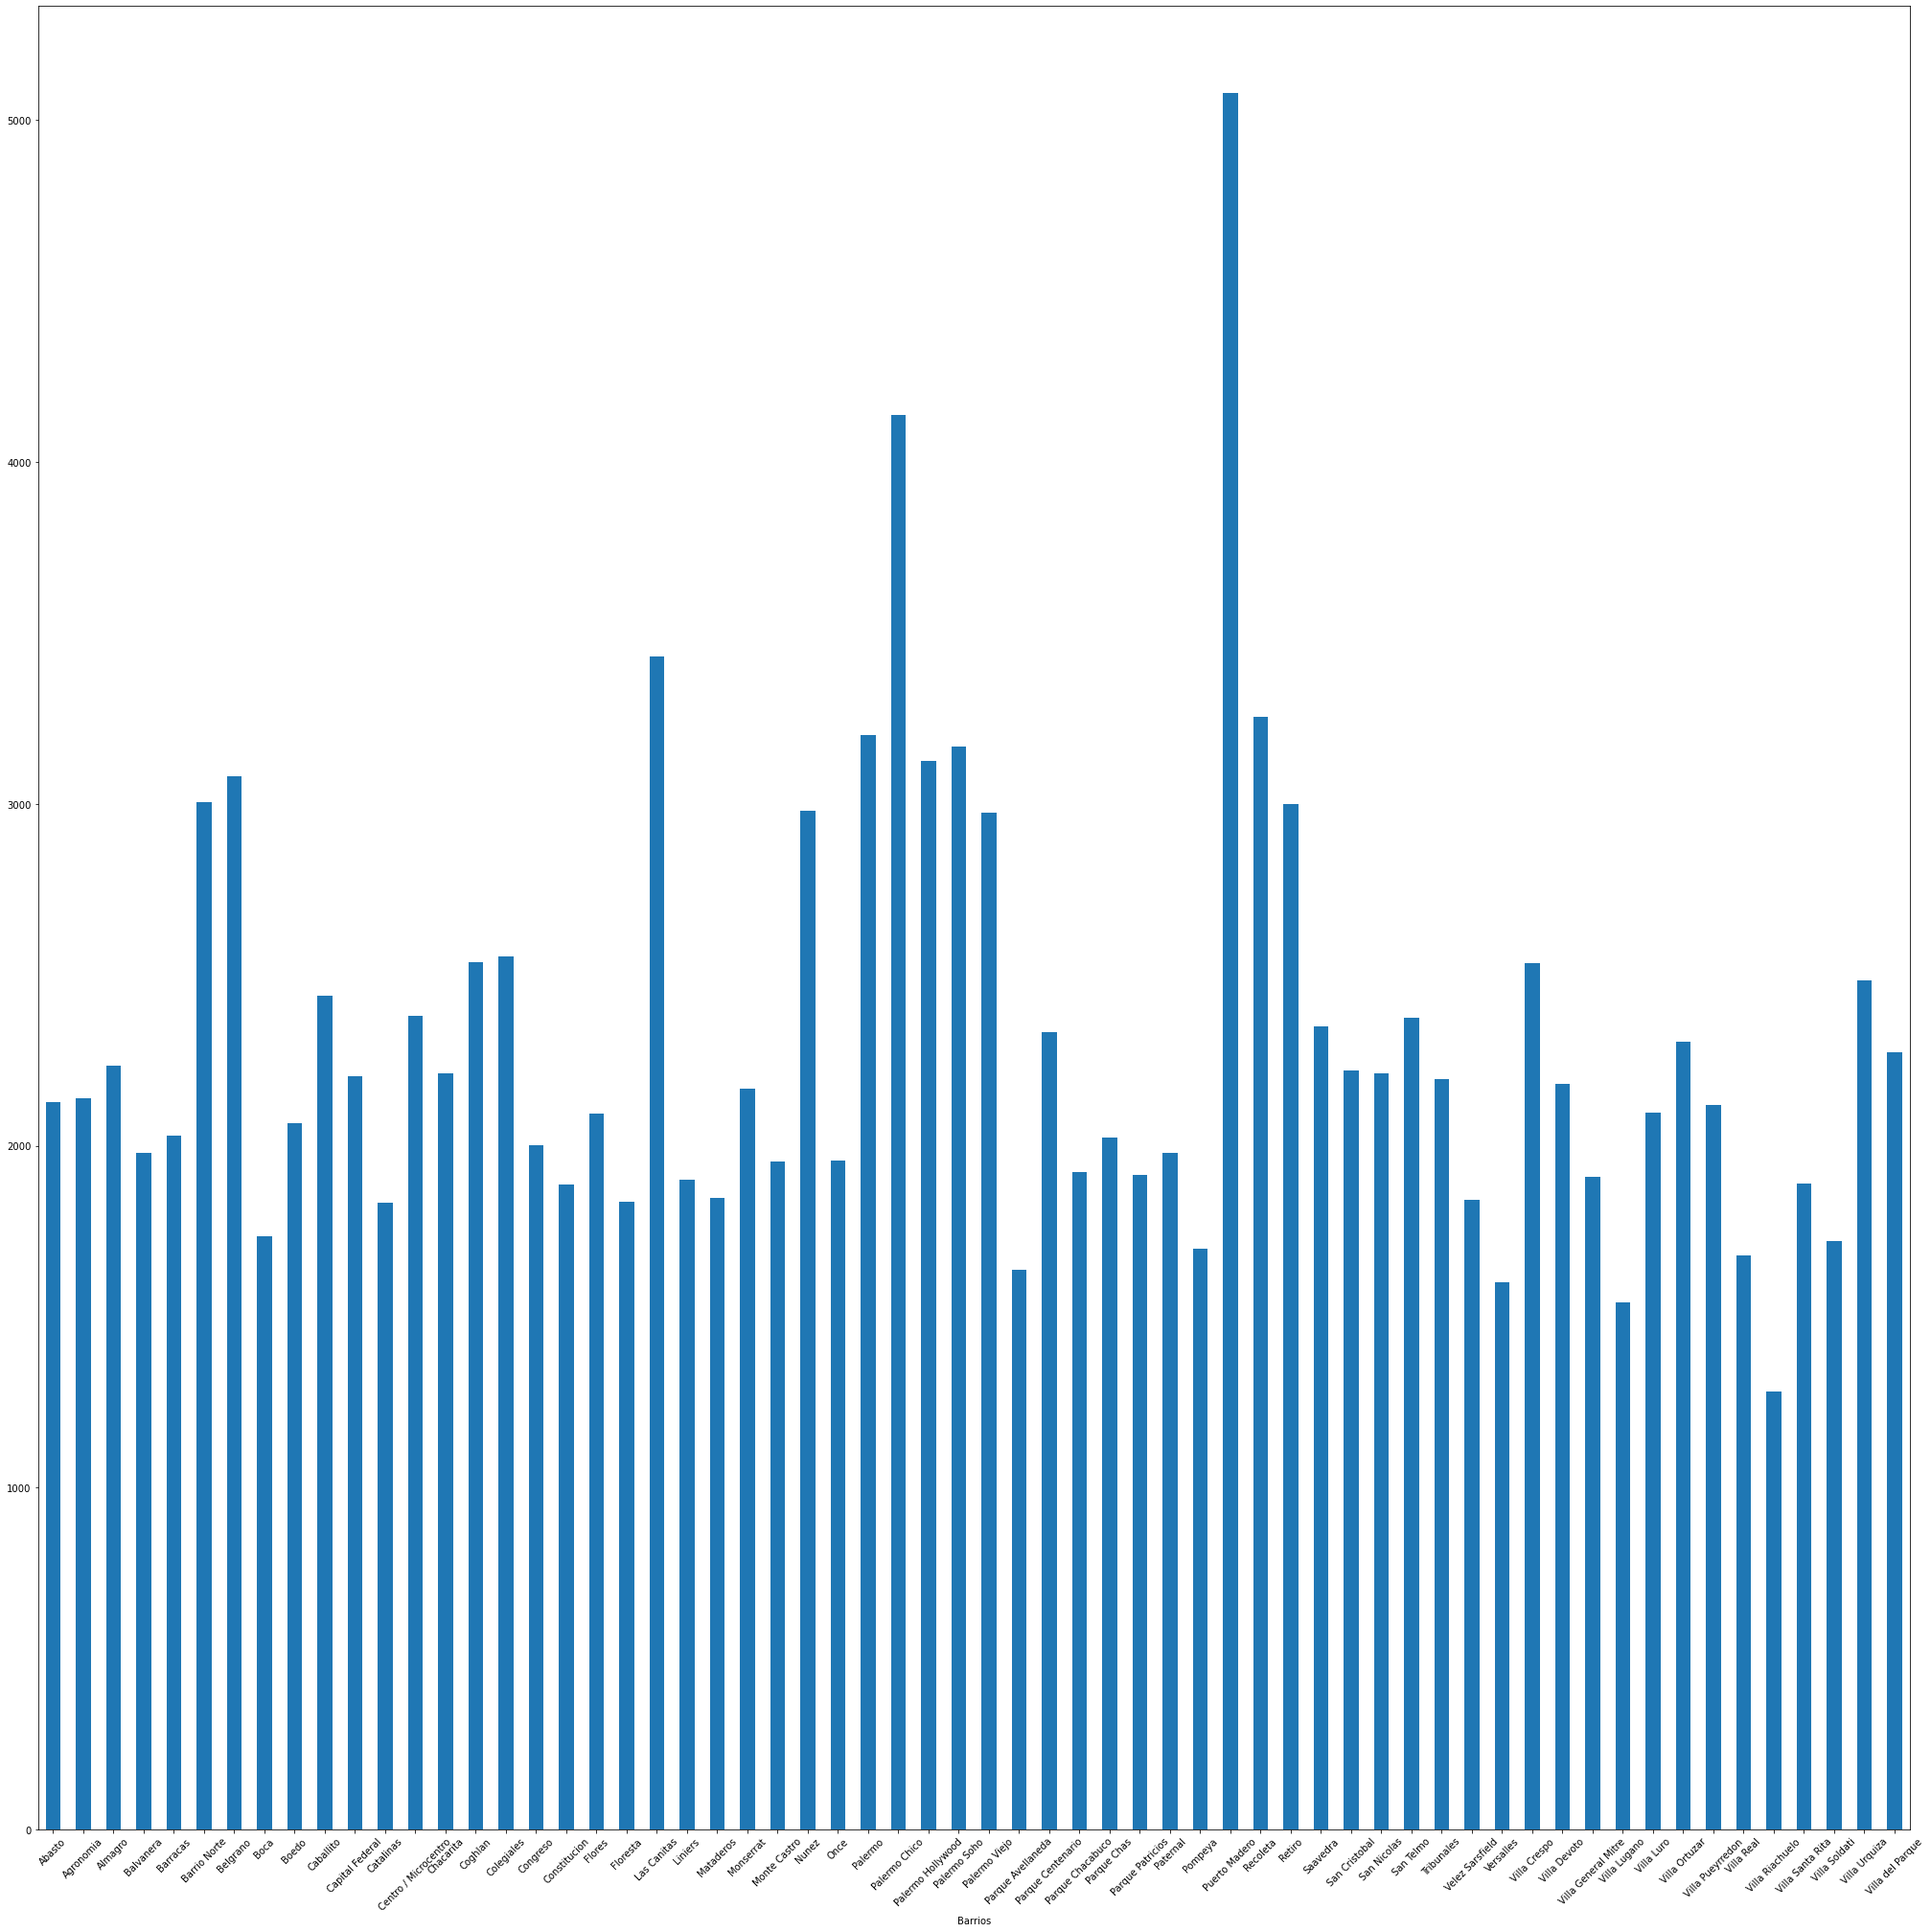

In [24]:
serie_x=pd.unique(propiedades_capital2.place_name)
serie_x
serie_y=propiedades_capital2[removed_outliers].groupby('place_name').price_usd_per_m2.mean()
serie_y.plot.bar(rot=45,figsize=(35,35), xlabel='Barrios')

In [25]:
# me quedo con las rows con geodata

gdata=propiedades_capital2[~propiedades_capital2['lat-lon'].isnull()]
print(len(gdata))

23770


In [26]:
df=gdata[0:3000]


fig = px.scatter_mapbox(df, lat="lat", lon="lon", zoom=5, height=600)
fig.update_layout(mapbox_style="white-bg")
fig.show()

In [27]:
fig = px.scatter_mapbox(df, lat="lat", lon="lon", zoom=9, height=600)
fig.update_layout(mapbox_style="carto-positron")

fig.show()

In [28]:
# uso el encoding latin1 por que hay nombres de barrios con tildes, si uso utf8 se pincha

polys=pd.read_csv('https://raw.githubusercontent.com/francodegio/DigitalHouse/master/barrios.csv',encoding='latin1')
cols2 = polys.select_dtypes(include=[np.object]).columns
polys.BARRIO[32]='POMPEYA'
polys.BARRIO[25]='VILLA GENERAL MITRE'
#Villa General Mitre
polys[cols2]= polys[cols2].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))
polys.describe

C:\Users\edgar\AppData\Local\Temp/ipykernel_16292/1612765106.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\edgar\AppData\Local\Temp/ipykernel_16292/1612765106.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<bound method NDFrame.describe of                                                   WKT               BARRIO  \
0   POLYGON ((-58.4528200492791 -34.5959886570639,...            CHACARITA   
1   POLYGON ((-58.4655768128541 -34.5965577078058,...             PATERNAL   
2   POLYGON ((-58.4237529813037 -34.5978273383243,...         VILLA CRESPO   
3   POLYGON ((-58.4946097568899 -34.6148652395239,...     VILLA DEL PARQUE   
4   POLYGON ((-58.4128700313089 -34.6141162515854,...              ALMAGRO   
5   POLYGON ((-58.4306058283309 -34.6070470885963,...            CABALLITO   
6   POLYGON ((-58.4819203599833 -34.6242871724757,...     VILLA SANTA RITA   
7   POLYGON ((-58.5034920611534 -34.6240324216321,...         MONTE CASTRO   
8   POLYGON ((-58.525116079791 -34.613999981063,-5...           VILLA REAL   
9   POLYGON ((-58.4452515823782 -34.6420397134706,...               FLORES   
10  POLYGON ((-58.4833907036583 -34.6241108718058,...             FLORESTA   
11  POLYGON ((-58.378630078175

In [29]:
# probemos con el primero

poly=polys.iloc[0].WKT
poly

'POLYGON ((-58.4528200492791 -34.5959886570639,-58.453655193137 -34.5965557163041,-58.4537674321647 -34.5966342484152,-58.4538163134148 -34.5966684788922,-58.4547947928051 -34.5973527273644,-58.4554840815948 -34.5978347610252,-58.4559204833296 -34.5976953435829,-58.4560093721285 -34.5976669530232,-58.4560576047802 -34.5976515472868,-58.4562363723257 -34.5975900748435,-58.4564940053845 -34.597501563774,-58.4570733158433 -34.5973024999733,-58.4576142986162 -34.5971165306991,-58.4578298572666 -34.5970394940224,-58.4579314199407 -34.5970031094655,-58.4579383597538 -34.5970006235554,-58.457939151188 -34.5970004324803,-58.4580314840712 -34.5969781271249,-58.4582467474022 -34.5969261254882,-58.4592081863103 -34.5966936826245,-58.4592753814056 -34.5966774864904,-58.4607717313584 -34.5965908256843,-58.461008489241 -34.5965771669178,-58.461500184562 -34.5965469590603,-58.4615048306102 -34.5965466787569,-58.4623220712384 -34.5965110490604,-58.4624802220071 -34.5965042183086,-58.4625206541306 -34.

In [30]:
# para que plotly grafique poligonos, se lo tenemos que pasar en el formato GEOjson
# esta libreria convierte strings wkt en GEOJSON

from geomet import wkt
gjson=wkt.loads(poly)

In [31]:
# necesitamos pasar las geometrias en este formato
# geojson (GeoJSON-formatted dict) – Must contain a Polygon feature collection, with IDs, which are references from locations.
# el input es un GEOJSON, un diccionario del tipo feature collection, las features es la lista de las shapes, con su geometria y su id
#

#un dict con esta llave general y una lista de 'features' que son los gjson que tira el geomet de cada poligono

gd=dict({'type': 'FeatureCollection' ,'features' : [dict({'geometry': gjson , 'id' : 'CHACARITA' })]})

In [32]:
# polys es el df comun y corriente de pandas
# gd es un diccionario con las geometrias en geojson
# con locations le digo en que columna del df esta las ID de los poligonos del dict GD


fig = px.choropleth_mapbox(polys,geojson=gd, locations='BARRIO', mapbox_style="carto-positron",
                           center = {"lat": -34.6, "lon": -58.35}, 
                           opacity=0.5, zoom= 10, height=500)
fig.show()

In [33]:
# Nesecito la lista de diccionarios con la geo y el id de las shapes, 
# uso el mismo del dataframe para generar esta lista, itero por fila convierto el WKT y saco el ID
# el iterrows tira indice y la serie fila, por eso el for i,x, pero solo uso el x

shapes=[ dict({'geometry': wkt.loads(x.WKT) , 'id' : x.BARRIO }) for i,x in polys.iterrows()] 

# ahora armo el diccionario GeoJSON con esta lista:

gd2=dict({'type': 'FeatureCollection' ,'features' : shapes })


In [34]:
fig = px.choropleth_mapbox(polys,geojson=gd2, locations='BARRIO', mapbox_style="carto-positron",center = {"lat": -34.6, "lon": -58.35},   opacity=0.5, zoom= 10, height=500)
fig.show()
# puedo agregarle mas info, por ejemplo que el color del poligono refleje el precio promedio para cada barrio, solo bastara agregarle esa informacion al dataframe polys

In [35]:
propiedades_capital2['place_name'].unique()

array(['Mataderos', 'Liniers', 'Belgrano', 'Palermo Soho', 'Palermo',
       'Flores', 'Boedo', 'Las Canitas', 'Puerto Madero', 'Balvanera',
       'Caballito', 'Nunez', 'San Telmo', 'Almagro', 'Capital Federal',
       'Colegiales', 'Floresta', 'Barrio Norte', 'Barracas', 'Recoleta',
       'Congreso', 'Villa Crespo', 'Chacarita', 'Constitucion',
       'Villa Urquiza', 'Palermo Hollywood', 'Saavedra', 'Monserrat',
       'Pompeya', 'Parque Chas', 'Paternal', 'Agronomia',
       'Villa Pueyrredon', 'Coghlan', 'Parque Centenario',
       'Palermo Chico', 'Villa Luro', 'Villa Devoto', 'Boca',
       'Parque Avellaneda', 'San Cristobal', 'Velez Sarsfield', 'Abasto',
       'Versalles', 'Villa del Parque', 'Monte Castro', 'Retiro',
       'Parque Patricios', 'San Nicolas', 'Villa Santa Rita',
       'Centro / Microcentro', 'Once', 'Tribunales', 'Parque Chacabuco',
       'Catalinas', 'Villa General Mitre', 'Palermo Viejo',
       'Villa Lugano', 'Villa Ortuzar', 'Villa Soldati', 'Villa Re

In [36]:
df3=propiedades_capital2[removed_outliers].groupby('place_name').mean()
df3

Unnamed: 0  geonames_id        lat        lon  \
place_name                                                          
Abasto            57175.137500          NaN -34.603673 -58.411736   
Agronomia         59795.625000    3436487.0 -34.592184 -58.484367   
Almagro           54884.670951    3436397.0 -34.607842 -58.421786   
Balvanera         60359.042129    6693228.0 -34.609446 -58.402676   
Barracas          48457.490446    3436134.0 -34.637392 -58.373852   
...                        ...          ...        ...        ...   
Villa Riachuelo   38006.000000    3427379.0 -34.693796 -58.468551   
Villa Santa Rita  36561.037037    6693230.0 -34.616511 -58.478164   
Villa Soldati     10857.000000    3427366.0 -34.666546 -58.473611   
Villa Urquiza     77628.606512    3433775.0 -34.572512 -58.482259   
Villa del Parque  75614.226586    3427455.0 -34.606805 -58.487802   

                          price  price_aprox_local_currency  price_aprox_usd  \
place_name                                                                     
Abasto            184785.187500                2.934838e+06    166331.623375   
Agronomia         148745.000000                2.624531e+06    148745.000000   
Almagro           214853.541131                2.652447e+06    150327.129897   
Balvanera         177046.090909                2.900588e+06    164390.496142   
Barracas          185310.095541                3.172241e+06    179786.381369   
...                         ...                         ...              ...   
Villa Riachuelo   175000.000000                3.087788e+06    175000.000000   
Villa Santa Rita  208555.555556                3.679858e+06    208555.555556   
Villa Soldati      86000.000000                1.517427e+06     86000.000000   
Villa Urquiza     443537.586977                2.913460e+06    165120.021023   
Villa del Parque  206105.537764                3.070190e+06    174002.646979   

                  surface_total_in_m2  surface_covered_in_m2  \
place_name                                                     
Abasto                      85.200000              73.786667   
Agronomia                   78.541667              70.000000   
Almagro                     72.721080              69.080475   
Balvanera                   88.403548              87.947619   
Barracas                    94.796178              82.861017   
...                               ...                    ...   
Villa Riachuelo            136.000000             108.000000   
Villa Santa Rita           126.518519              79.407407   
Villa Soldati               50.000000              50.000000   
Villa Urquiza               69.420465              59.281220   
Villa del Parque            82.492447              69.401235   

                  price_usd_per_m2  price_per_m2     floor     rooms  \
place_name                                                             
Abasto                 2126.383464   2665.325533  2.375000  2.486486   
Agronomia              2139.282478   2483.673599       NaN  2.500000   
Almagro                2235.323869   4235.366844  4.380282  2.570297   
Balvanera              1979.445982   2603.513776  5.253731  2.810714   
Barracas               2028.838611   2422.043180  3.866667  2.782609   
...                            ...           ...       ...       ...   
Villa Riachuelo        1281.420765   1803.030303       NaN       NaN   
Villa Santa Rita       1889.186620  26404.562359  6.250000  2.687500   
Villa Soldati          1720.000000   1720.000000       NaN  3.000000   
Villa Urquiza          2484.900034   8310.223516  2.923077  2.295082   
Villa del Parque       2272.342802   5346.339243  5.571429  2.723404   

                     expenses  price_usd_per_m2_mean  
place_name                                            
Abasto            1888.148148            2057.529147  
Agronomia         3264.714286            2088.124134  
Almagro           2476.464419            2749.102521  
Balvanera         2484.012121       

In [37]:
df3.index = df3.index.map(str.lower)
# paso a minusculas
polys.BARRIO=polys.BARRIO.apply(str.lower)
# le cambio el nombre a las columnas
polys=polys.rename(columns={"BARRIO": "barrio"})


In [38]:
# este metodo me devuelve el iloc de una string en la lista de indices, si es que existe
df3.index.get_loc('chacarita')

13

In [39]:
#con ese indice miro un valor
df3.iloc[13].price_usd_per_m2

2212.6448817983523

In [40]:
# armo un for para capturar los valores, no es lo mas elegante, 
# pero necesitaba un try para los barrios que no encuentre

pm2=[]
for i,x in polys.iterrows():
    try:
        j=df3.index.get_loc(x.barrio)
        pm2.append(df3.iloc[j].price_usd_per_m2)
    except:
        # printeo los que no encuentra
        print(x.barrio)       
        pm2.append(0.0)
    

In [41]:
# pongo esta columna en polys
polys['m2']=pm2
polys.head()

WKT            barrio  \
0  POLYGON ((-58.4528200492791 -34.5959886570639,...         chacarita   
1  POLYGON ((-58.4655768128541 -34.5965577078058,...          paternal   
2  POLYGON ((-58.4237529813037 -34.5978273383243,...      villa crespo   
3  POLYGON ((-58.4946097568899 -34.6148652395239,...  villa del parque   
4  POLYGON ((-58.4128700313089 -34.6141162515854,...           almagro   

   COMUNA    PERIMETRO          AREA           m2  
0    15.0  7725.695228  3.118101e+06  2212.644882  
1    15.0  7087.513295  2.229829e+06  1978.310473  
2    15.0  8132.699348  3.613584e+06  2533.102306  
3    11.0  7705.389797  3.399596e+06  2272.342802  
4     5.0  8537.901368  4.050752e+06  2235.323869

In [42]:
# lo armo de nuevo al geojson por que pase a minusculas los barrios y por lo tanto las id de las shapes

shapes=[ dict({'geometry': wkt.loads(x.WKT) , 'id' : x.barrio }) for i,x in polys.iterrows()] 
# ahora armo el diccionario GeoJSON con esta lista:

gd2=dict({'type': 'FeatureCollection' ,'features' : shapes })

In [43]:
fig = px.choropleth_mapbox(polys,geojson=gd2, locations='barrio', color='m2' ,mapbox_style="carto-positron",center = {"lat": -34.6, "lon": -58.35},   
                           opacity=0.5, zoom= 10, height=500 ,  color_continuous_scale="Viridis")
fig.show()

In [44]:
"""'Unnamed: 0', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail'"""

#print(propiedades_capital2.groupby(['property_type','state_name']).price_per_m2.describe())
propiedades_capital2.state_name.value_counts().head(50)

Capital Federal    32316
Name: state_name, dtype: int64

In [45]:
propiedades_capital2.state_name.isna().count

<bound method Series.count of 0        False
1        False
2        False
3        False
4        False
         ...  
32311    False
32312    False
32313    False
32314    False
32315    False
Name: state_name, Length: 32316, dtype: bool>

In [46]:
propiedades.price_aprox_usd.isna().count

<bound method Series.count of 0         False
1         False
2         False
3         False
4         False
          ...  
121215    False
121216    False
121217    False
121218    False
121219    False
Name: price_aprox_usd, Length: 121220, dtype: bool>

In [47]:
propiedades_capital2.columns

Index(['Unnamed: 0', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail', 'price_usd_per_m2_mean'],
      dtype='object')

In [48]:
#=

#propiedades_capital_boedo2=propiedades_capital_boedo[['price_usd_per_m2','place_name']]
#propiedades_capital_boedo2.describe()
propiedades_removed_outliers = propiedades.price_usd_per_m2.between(propiedades.price_usd_per_m2.quantile(.05), propiedades.price_usd_per_m2.quantile(.95))
print(propiedades.price_usd_per_m2.mean())
print(propiedades.price_usd_per_m2[propiedades_removed_outliers].mean())
#propiedades_capital_boedo2.price_usd_per_m2=[propiedades_capital_boedo2.price_usd_per_m2.between(propiedades_capital_boedo2.price_usd_per_m2.quantile(.15), propiedades_capital_boedo2.price_usd_per_m2.quantile(.85))] 

propiedades_sin_outliers=propiedades[propiedades_removed_outliers]
propiedades_sin_outliers.price_usd_per_m2.describe()

2160.086915888256
1862.90727228266


count    61757.000000
mean      1862.907272
std        798.583104
min        357.142857
25%       1285.714286
50%       1800.000000
75%       2400.000000
max       4081.819192
Name: price_usd_per_m2, dtype: float64

In [49]:
provincias_a_usar=propiedades_sin_outliers.state_name.value_counts().head(5).index.tolist()
#provincias_a_usar
propiedades_con_provincias_limpias=propiedades_sin_outliers.loc[(propiedades_sin_outliers.state_name.isin(provincias_a_usar))]
propiedades_con_provincias_limpias.groupby('property_type').expenses.describe()

count         mean            std  min     25%     50%  \
property_type                                                            
PH              264.0   794.640152     852.546204  1.0   172.5   500.0   
apartment      7740.0  5328.758915  160751.925983  1.0  1000.0  1800.0   
house          1262.0  5261.383518    3698.588380  1.0  3200.0  4800.0   
store           220.0  2016.600000    2809.315971  1.0   174.0  1111.0   

                  75%         max  
property_type                      
PH             1200.0      6000.0  
apartment      3300.0  10001500.0  
house          6737.5     40000.0  
store          2850.0     17500.0

In [50]:
df_limpio=propiedades_con_provincias_limpias[['property_type','state_name','price_aprox_usd','surface_total_in_m2','price_usd_per_m2']]
df_limpio.columns

Index(['property_type', 'state_name', 'price_aprox_usd', 'surface_total_in_m2',
       'price_usd_per_m2'],
      dtype='object')

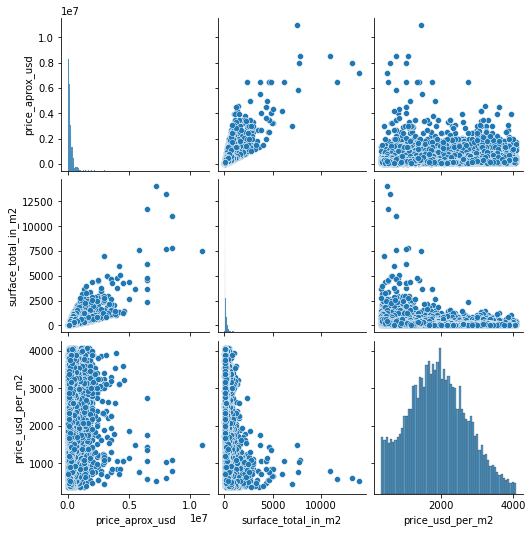

In [51]:
import seaborn as sns
sns.color_palette("rocket", as_cmap=True)
g=sns.pairplot(df_limpio, palette='rocket')

In [52]:
pd.set_option('display.max_colwidth', -1)

propiedades_sin_outliers.description.loc[propiedades_sin_outliers.property_type=="apartment"]=propiedades_sin_outliers.description.str.lower()
cadena=str(propiedades_sin_outliers.description.sample(1))

cadena

C:\Users\edgar\AppData\Local\Temp/ipykernel_16292/1262622851.py:1: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.

C:\Users\edgar\Anaconda3\envs\dhdsblend2021\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\edgar\AppData\Local\Temp/ipykernel_16292/1262622851.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



'54972    ROSSI BIENES RAICES VENDE CASA EN VILLA CARLOS PAZ CON EXCELENTE VISTA AL LAGO EN BARRIO LAS VERTIENTES.Caracteristicas:- Casa con dos plantas.- Planta Baja dispone de:             Living - comedor luminosos con puerta de acceso doble.             Bano completo social.             Cocina - comedor con barra desayunadora. Dispone de muebles bajo mesada con interiores y cajones, y alacena de madera. Artefacto de cocina con extractor. Mesada de granito con bacha de acero doble con monocomando.              Dormitorio con bano en suite y espacio de guardado.             - Planta Alta:             Tres dormitorios. El principal con salida a balcon, con vestidor y bano en suite. Los otros dos con placares grandes.             Bano completo con hidromasajes.             Espacio de estar con salida a balcon con vista al lago.             Otro espacio para uso de oficina con vista al frente de la casa.            - En su exterior cuenta con ingreso de jerarquia con rejas y puerta dobl

In [53]:
txt="\w+(?=\s+dorm|\s+amb|\s+habit)"# funciona pero no establece prioridades de busqueda - tenemos 2 ambientes y 1 habitacion
#txt="\b(?:one|two|three)\b"
txt_re=re.compile(txt)
#txt = "The rain in Spain"
#x = re.findall("ai", txt)
#print(x)
rooms_tmp=re.findall(txt_re,cadena)
print(rooms_tmp)
try: 
    
    rooms=rooms_tmp[0]
    print(rooms)
    if rooms.isdigit()==False:
        if rooms=='un':
            rooms=1
        elif rooms=='dos':
            rooms=2
except IndexError:
    rooms='1'
if rooms=='mono':
    rooms='1'
print("habitaciones: "+str(rooms))


['Tres', 'con']
Tres
habitaciones: Tres


In [54]:
#usamos counts como bandera de la ocurrencia de esa palabra
rooms=0
if  cadena.count("monoambiente") >0:
    print("monoambiente")
    rooms=1

#if  cadena.count("mono ambiente") >1:
#    print("mono ambiente")
#    rooms=1
    
elif cadena.count("ambiente")>0:
    print("ambiente")
    cadena2=cadena.split("ambiente", 1)
    
elif cadena.count("ambientes")>0:
    print("ambientes")
    cadena2=cadena.split("ambientes", 1)
    
elif cadena.count("habitacion")>0:
    print("habitacion")
    cadena2=cadena.split("habitacion", 1)
    
elif cadena.count("habitaciones")>0:
    print("habitaciones")
    cadena2=cadena.split("habitaciones", 1)
    
elif cadena.count("dormitorios")>0:
    print("dormitorios")
    cadena2=cadena.split("dormitorios", 1)
    
rooms=int(rooms)
rooms

ambiente


0

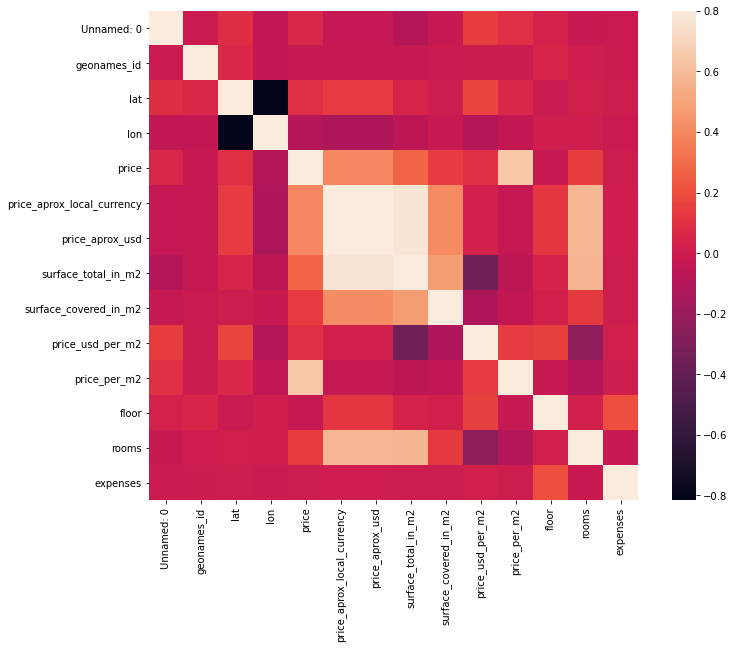

In [55]:
import matplotlib.pyplot as plt
corrmat = propiedades_con_provincias_limpias.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

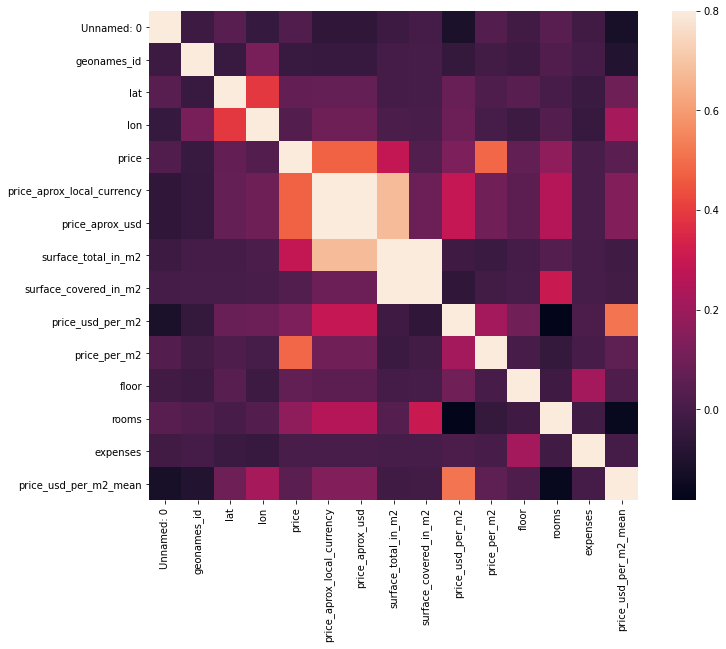

In [56]:
import matplotlib.pyplot as plt
corrmat = propiedades_capital2.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

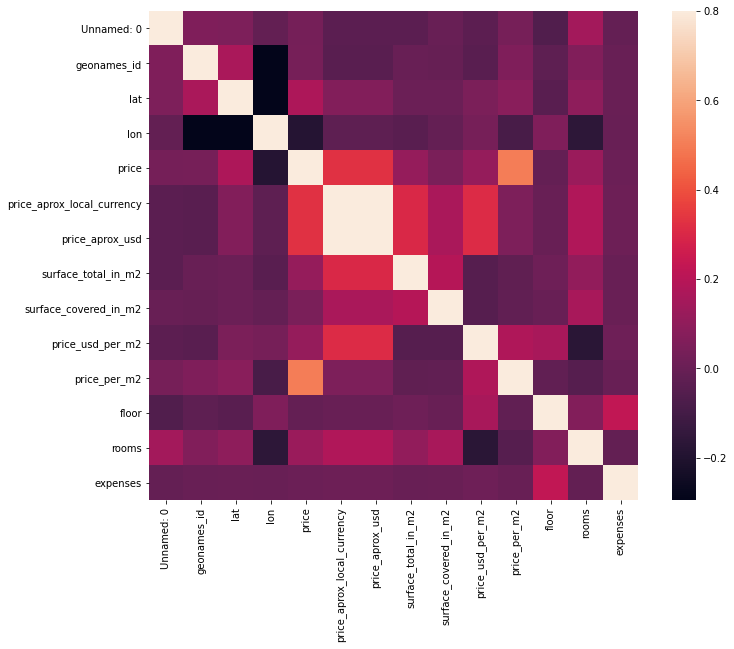

In [57]:
import matplotlib.pyplot as plt
corrmat = propiedades.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [58]:
propiedades_con_provincias_limpias.columns

Index(['Unnamed: 0', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail'],
      dtype='object')

In [59]:
dummies=propiedades_capital2[['property_type','place_name','price_aprox_usd', 'price_usd_per_m2']]
df_dummies = pd.get_dummies(dummies)
df_dummies.shape

(32316, 68)

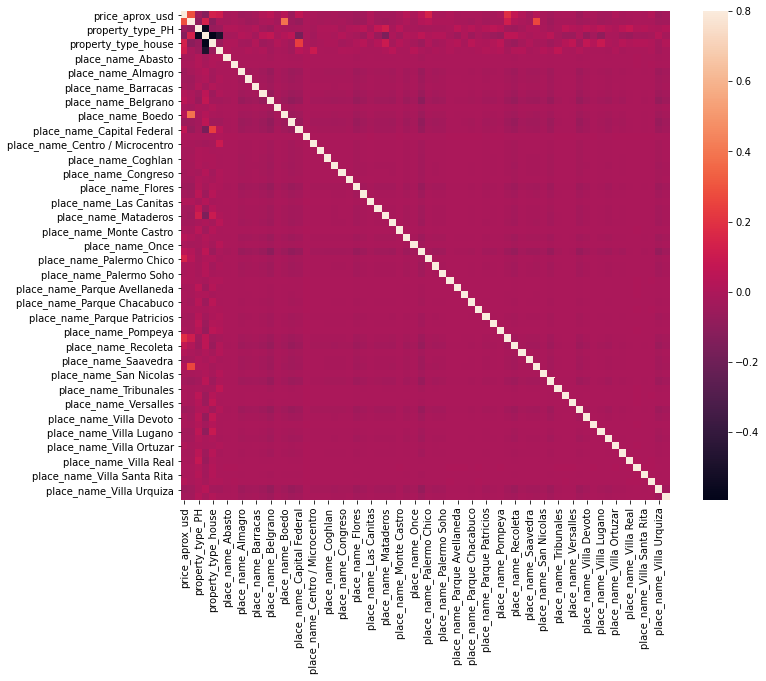

In [60]:
corrmat = df_dummies.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

rooms

In [61]:
barrios=propiedades_capital2.place_name.unique().tolist()


In [62]:
barrios_numeros=list(range(0, len(barrios)))
#barrios_numeros_df=pd.DataFrame(barrios_numeros)

In [63]:
barrios_numeros

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61]

In [64]:
#pricem2USD_fill_values_df= pd.DataFrame(pricem2USD_fill_values)
#barrios_numeros_df.reset_index(inplace=True)
#propiedades_capital3=propiedades_capital2.merge(barrios_numeros_df, on= 'place_name', how='left', suffixes = ("", "_numero"))

In [65]:
pricem2USD_fill_values_df
barrios_por_numeros = np.array([(barrios),(barrios_numeros)])
#pricem2USD_fill_values_df.reset_index(inplace=True)
#propiedades_capital2=propiedades_capital.merge(pricem2USD_fill_values_df, on= 'place_name', how='left', suffixes = ("", "_mean"))

In [66]:
barrios_por_numeros=np.rot90(barrios_por_numeros)


In [67]:
#nombres_barrios_fill_values=propiedades_capital.groupby('place_name').price_usd_per_m2.mean()
nombres_barrios_fill_values = pd.DataFrame(data = barrios_por_numeros, columns=['place_name','number'])
nombres_barrios_fill_values.reset_index(inplace=True)
propiedades_capital3=propiedades_capital2.merge(nombres_barrios_fill_values, on= 'place_name', how='left', suffixes = ("", "_por_numero"))
propiedades_capital3.number=propiedades_capital3.number.astype(float)

In [68]:
propiedades_capital3.columns

Index(['Unnamed: 0', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail', 'price_usd_per_m2_mean', 'index', 'number'],
      dtype='object')

In [69]:
propiedades_capital3.groupby('number').place_name.value_counts()

number  place_name     
0.0     Mataderos          418 
1.0     Liniers            408 
2.0     Belgrano           2992
3.0     Palermo Soho       394 
4.0     Palermo            2885
                           ... 
57.0    Villa Lugano       205 
58.0    Villa Ortuzar      86  
59.0    Villa Soldati      15  
60.0    Villa Real         37  
61.0    Villa Riachuelo    6   
Name: place_name, Length: 62, dtype: int64

In [70]:
propiedades_capital3.dtypes

Unnamed: 0                    int64  
operation                     object 
property_type                 object 
place_name                    object 
place_with_parent_names       object 
country_name                  object 
state_name                    object 
geonames_id                   float64
lat-lon                       object 
lat                           float64
lon                           float64
price                         float64
currency                      object 
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                         float64
expenses                      float64
properati_url                 object 
description                   object 
title                         object 
image_thumbnail               object 
price_usd_pe

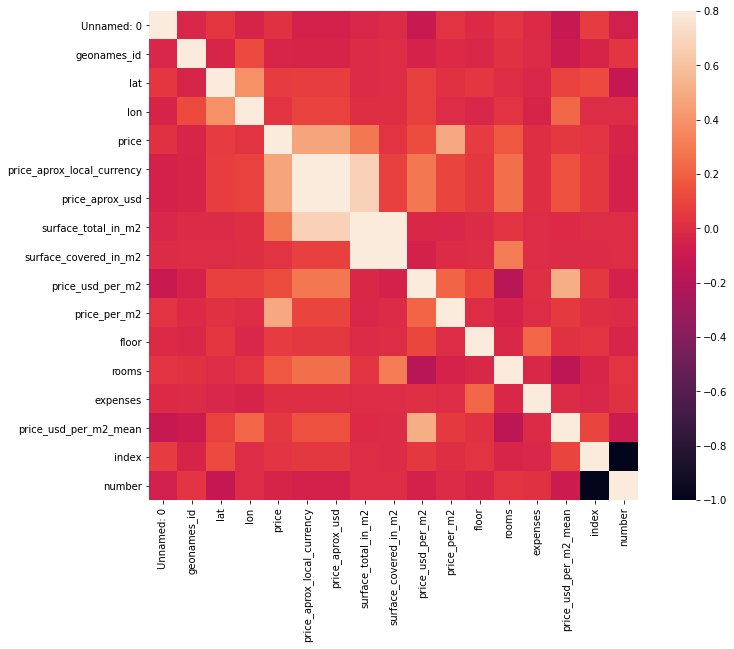

In [71]:
import matplotlib.pyplot as plt
corrmat = propiedades_capital3.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [72]:
corrmat

Unnamed: 0  geonames_id       lat       lon  \
Unnamed: 0                  1.000000   -0.024986     0.042367 -0.042785   
geonames_id                -0.024986    1.000000    -0.035278  0.119511   
lat                         0.042367   -0.035278     1.000000  0.391286   
lon                        -0.042785    0.119511     0.391286  1.000000   
price                       0.023648   -0.034008     0.067774  0.031134   
price_aprox_local_currency -0.057606   -0.039276     0.071113  0.091537   
price_aprox_usd            -0.057606   -0.039276     0.071113  0.091537   
surface_total_in_m2        -0.022693   -0.002075    -0.005002  0.012057   
surface_covered_in_m2      -0.003912   -0.000799    -0.000763  0.007738   
price_usd_per_m2           -0.111892   -0.047738     0.079817  0.089778   
price_per_m2                0.029502   -0.009464     0.019772 -0.001492   
floor                      -0.013058   -0.022097     0.046956 -0.027208   
rooms                       0.040610    0.021936     0.004800  0.028965   
expenses                   -0.012621   -0.004554    -0.029193 -0.039920   
price_usd_per_m2_mean      -0.119686   -0.093869     0.092868  0.222004   
index                       0.063538   -0.037276     0.124315  0.001519   
number                     -0.063538    0.037276    -0.124315 -0.001519   

                               price  price_aprox_local_currency  \
Unnamed: 0                  0.023648 -0.057606                     
geonames_id                -0.034008 -0.039276                     
lat                         0.067774  0.071113                     
lon                         0.031134  0.091537                     
price                       1.000000  0.474468                     
price_aprox_local_currency  0.474468  1.000000                     
price_aprox_usd             0.474468  1.000000                     
surface_total_in_m2         0.288473  0.678194                     
surface_covered_in_m2       0.027870  0.087913                     
price_usd_per_m2            0.129221  0.291370                     
price_per_m2                0.486642  0.102656                     
floor                       0.065512  0.053584                     
rooms                       0.173039  0.258215                     
expenses                    0.007567  0.009015                     
price_usd_per_m2_mean       0.050860  0.140806                     
index                       0.040219  0.051978                     
number                     -0.040219 -0.051978                     

                            price_aprox_usd  surface_total_in_m2  \
Unnamed: 0                 -0.057606        -0.022693              
geonames_id                -0.039276        -0.002075              
lat                         0.071113        -0.005002              
lon                         0.091537         0.012057              
price                       0.474468         0.288473              
price_aprox_local_currency  1.000000         0.678194              
price_aprox_usd             1.000000         0.678194              
surface_total_in_m2         0.678194         1.000000              
surface_covered_in_m2       0.087913         0.872890              
price_usd_per_m2            0.291370        -0.019951              
price_per_m2                0.102656        -0.029625              
floor                       0.053584        -0.004139              
rooms                       0.258215         0.034580              
expenses                    0.009015         0.001065              
price_usd_per_m2_mean       0.140806        -0.014655              
index                       0.051978        -0.001472              
number                     -0.051978         0.001472              

                            surface_covered_in_m2  price_usd_per_m2  \
Unnamed: 0                 -0.003912              -0.111892           
geonames_id                -0.000799              -0.047738           
lat           

In [73]:
propiedades_capital3.columns

Index(['Unnamed: 0', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail', 'price_usd_per_m2_mean', 'index', 'number'],
      dtype='object')

In [74]:
propiedades_capital_limpio=propiedades_capital3[['property_type','place_name','price','price_aprox_local_currency','price_aprox_usd','surface_total_in_m2',
       'surface_covered_in_m2','price_usd_per_m2','price_per_m2','floor','rooms','description','price_usd_per_m2_mean']]

In [75]:
propiedades_capital_limpio.shape

(32316, 13)

In [76]:
corrmat=propiedades_capital_limpio.corr().abs()
s=corrmat.unstack()
so = s.sort_values(kind='quicksort')
so

surface_covered_in_m2       floor                         0.000196
floor                       surface_covered_in_m2         0.000196
surface_total_in_m2         floor                         0.004139
floor                       surface_total_in_m2           0.004139
                            price_per_m2                  0.004227
                                                            ...   
price_aprox_local_currency  price_aprox_local_currency    1.000000
rooms                       rooms                         1.000000
price_usd_per_m2_mean       price_usd_per_m2_mean         1.000000
price_aprox_usd             price_aprox_local_currency    1.000000
price_aprox_local_currency  price_aprox_usd               1.000000
Length: 100, dtype: float64

<AxesSubplot:>

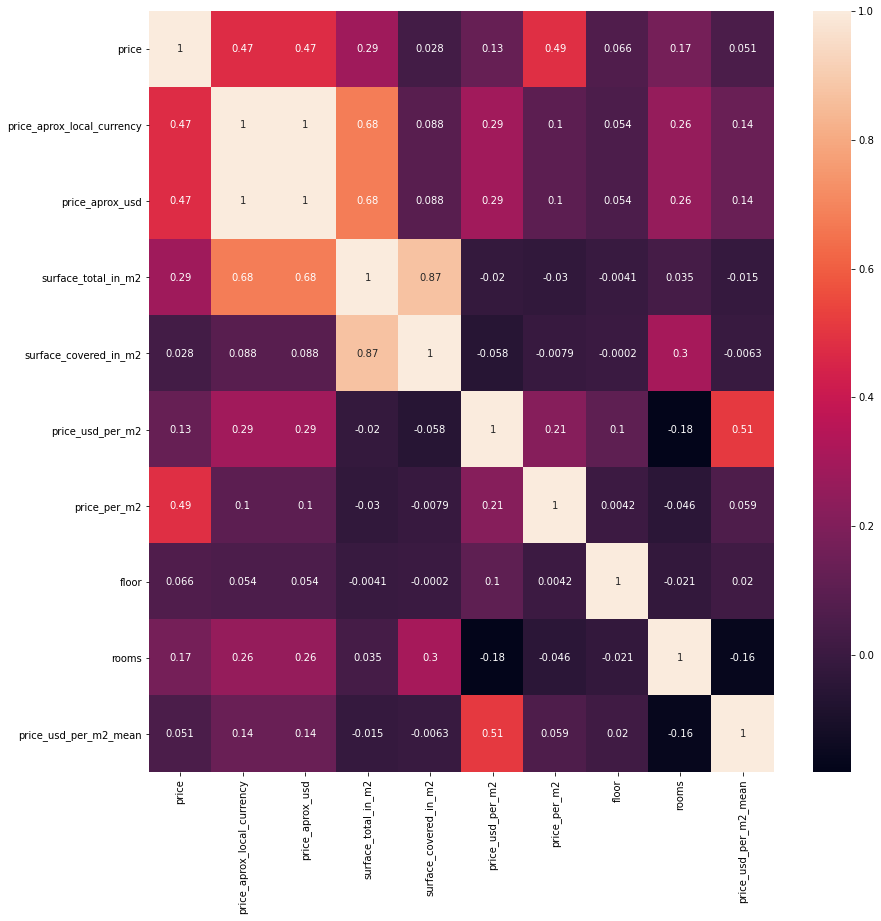

In [77]:
fig =plt.subplots(figsize=(14,14))
sns.heatmap(propiedades_capital_limpio.corr(), annot=True)

In [78]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
cloud_text = " ".join(review for review in propiedades_capital_limpio.description.astype(str))

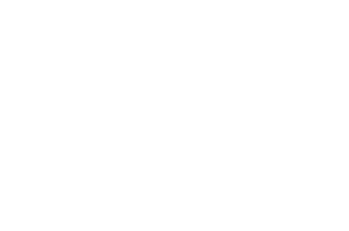

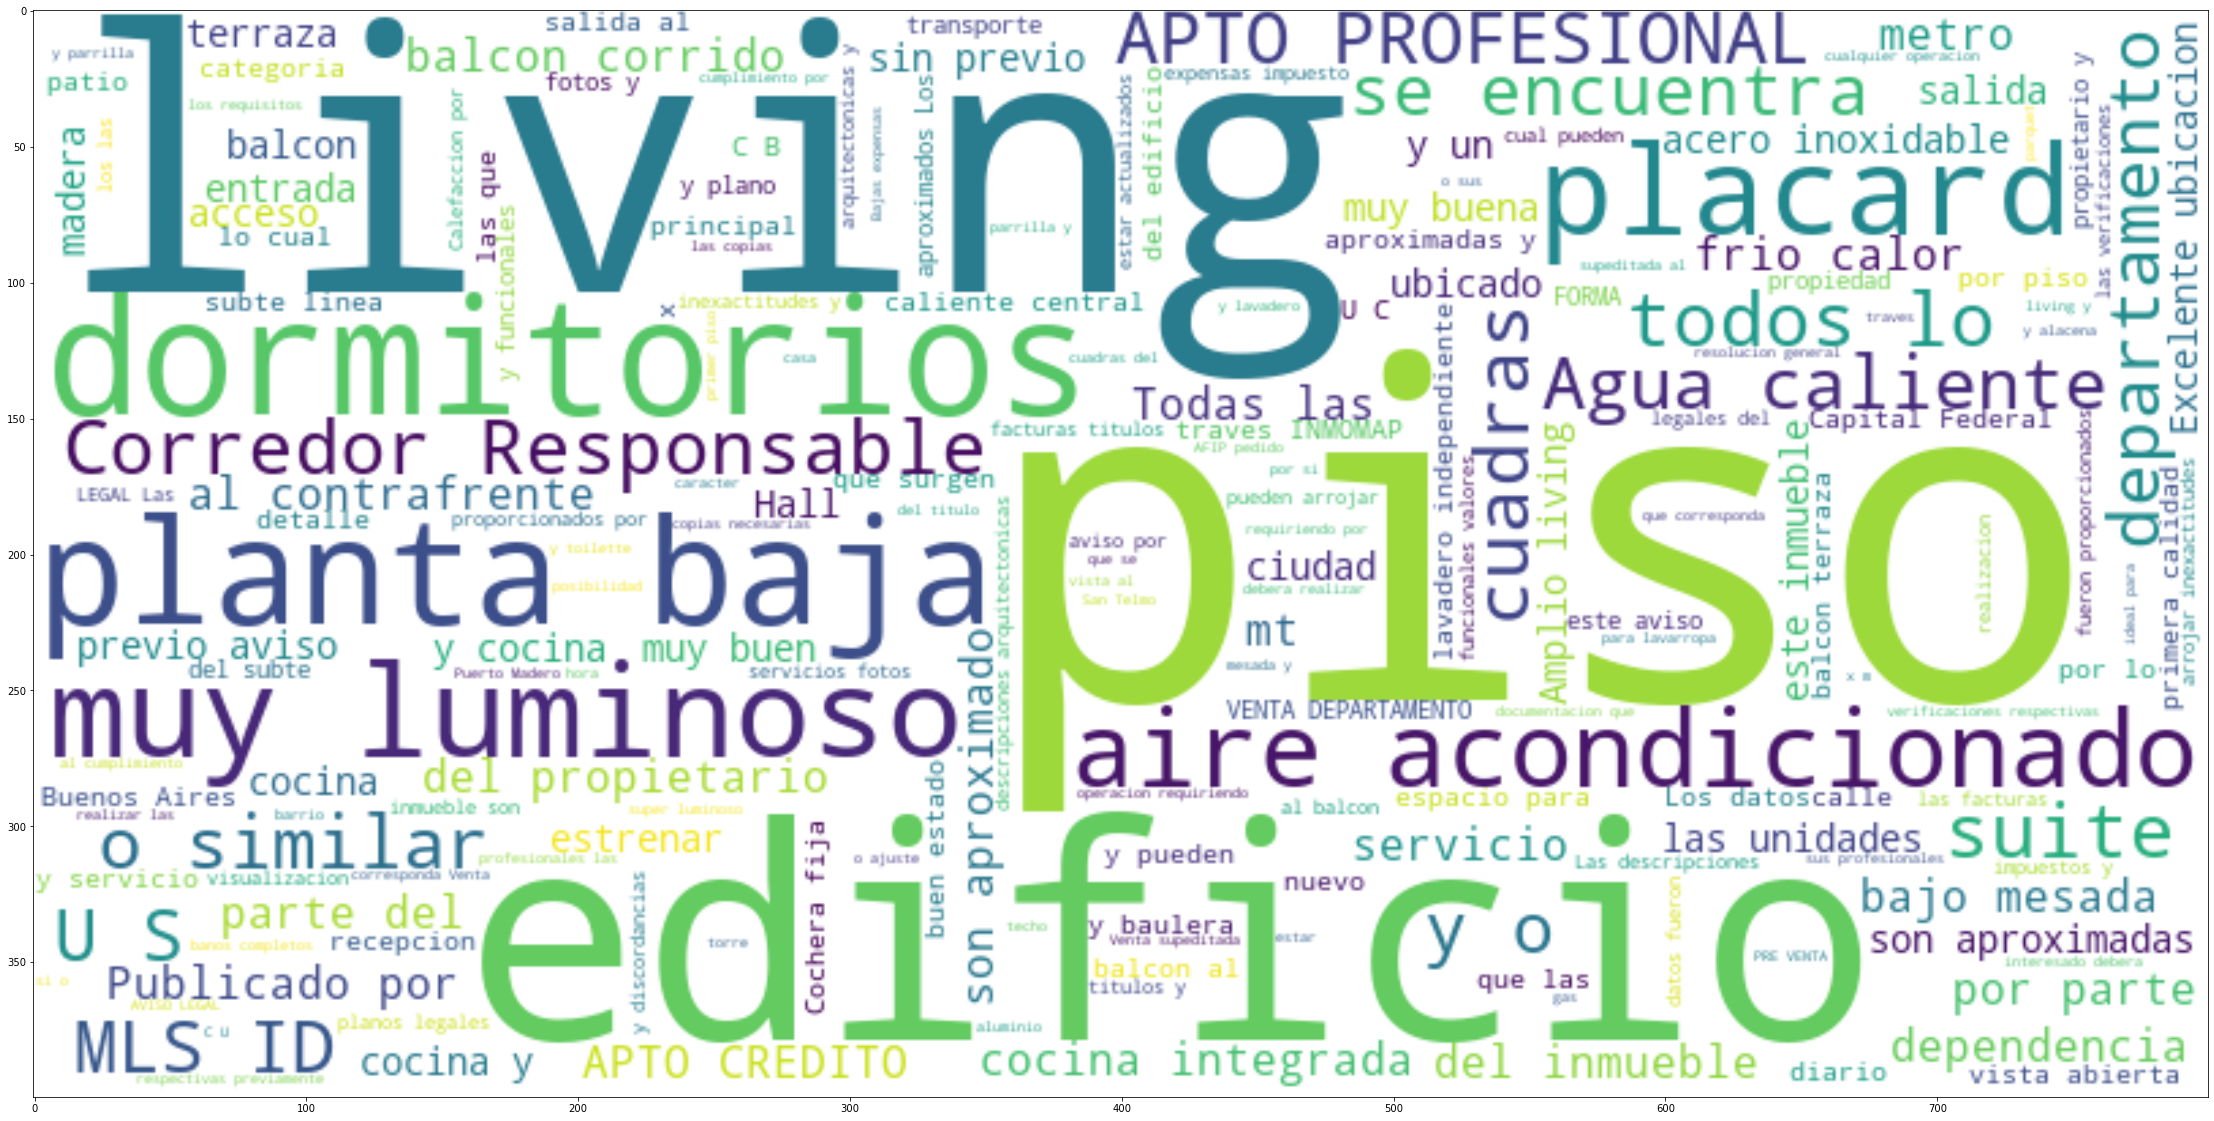

In [79]:
stopwords = set(STOPWORDS)
stopwords.update(["una", "dos", "tres", "oportunidad","de","la","baño","bano","cuadra","completo","comedor","ambiente","ambientes","frente", "cuenta","con","en","el","medidas","dormitorio"])

wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate(cloud_text)

# Display the generated image:
# the matplotlib way:

plt.axis("off")
plt.figure( figsize=(40,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In [80]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [85]:
propiedades_con_provincias_limpias.isna().sum()

Unnamed: 0                    0    
operation                     0    
property_type                 0    
place_name                    17   
place_with_parent_names       0    
country_name                  0    
state_name                    0    
geonames_id                   10611
lat-lon                       20778
lat                           20778
lon                           20778
price                         0    
currency                      0    
price_aprox_local_currency    0    
price_aprox_usd               0    
surface_total_in_m2           0    
surface_covered_in_m2         3298 
price_usd_per_m2              0    
price_per_m2                  3300 
floor                         49436
rooms                         32818
expenses                      42948
properati_url                 0    
description                   0    
title                         0    
image_thumbnail               723  
dtype: int64

In [86]:
#propiedades_capital_limpio_no_nan = provincias_a_usar[]

X = propiedades_capital_limpio_no_nan[['price_usd_per_m2', 'rooms', 'surface_total_in_m2']]

scaler = StandardScaler()

X_std = scaler.fit_transform(X)

y = propiedades_capital_limpio_no_nan['price_aprox_usd']

NameError: name 'propiedades_capital_limpio_no_nan' is not defined

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.3, random_state = 117)

model_ridge_cv = linear_model.RidgeCV(alphas= [0.3, 0.5, 1.0, 1.1, 1.15, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.3, 1.4, 1.5, 10.0], 
                                   fit_intercept=True, normalize=False, cv=10)

model_fit_ridge_cv = model_ridge_cv.fit(X_train, y_train)

print(model_fit_ridge_cv.alpha_)

print(model_fit_ridge_cv.best_score_)

In [ ]:
best_alpha = model_fit_ridge_cv.alpha_
model_ridge = linear_model.Ridge(alpha = best_alpha, fit_intercept = True, normalize = False)
model_fit_ridge = model_ridge.fit(X_train, y_train)
print(model_fit_ridge.coef_)
print(model_fit_ridge.intercept_)
print(model_fit_ridge.score(X_train, y_train))

In [ ]:
model_fit_ridge.score(X_test, y_test)